# **Training Data Processing**

1. Project Setup
2. Prepare UCP Data
3. Rasterize UCP Data
4. T

# **1. Project Setup**

### 1.1. Import Libraries

In [2]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lcz_classification.config import * 
from lcz_classification.dataset import fetch_metadata
from lcz_classification.util import merge_rasters, masked_study_area, smoothen_gdf, read_lcz_legend, rasterize_vector, generate_raster, get_overlapping_tiles, meter_to_deg, kml_to_gdf
# from lcz_classification.plots import map_training_areas
import fiona
import rioxarray as rio
import pandas as pd
import rasterio as r
from shapely.geometry import box
import geopandas as gpd
import xarray as xr
from rasterio.enums import Resampling
import numpy as np
from sklearn.model_selection import train_test_split
from rasterio.features import shapes
from shapely.ops import shape

- Parent directory for Cairo already exists, retrievine folder paths...
- Folder paths for Cairo retrieved.


In [14]:
study_area=fetch_metadata("STUDY_AREA")

UTM_CRS=study_area.estimate_utm_crs()
bounds=list(study_area.total_bounds)

lcz_legend=fetch_metadata('LCZ_LEGEND')

lcz_gdf=kml_to_gdf(LCZ_FP).to_crs(UTM_CRS)
lcz_gdf.dropna(subset='geometry',inplace=True)
lcz_gdf['class'] = [lcz_legend.set_index('class_id').loc[cl]['class'] for cl in lcz_gdf.Name]
# lcz_gdf['class_id'] = [lcz_legend.set_index('class_id').loc[cl]['class_id'] for cl in lcz_gdf.Name]
lcz_gdf['name'] = [lcz_legend.set_index('class_id').loc[cl]['name'] for cl in lcz_gdf.Name]
lcz_gdf['area_m2']=lcz_gdf.to_crs(UTM_CRS).area

Non-valid Layer: Local_062220


### 1.3. Setup Reference Raster

In [4]:

## Setup Reference Raster from Sentinel-2 Imagery
s2=rio.open_rasterio(S2_FP)
s2_ref=s2.isel(band=0)

# **2. Urban Canopy Layer Processing**

## 2.1. Sky View Factor

#### 2.1.1. Merge  DSM Layers 

In [5]:
dsm_files= [f"{DSM_RAW}/{tif}" for tif in os.listdir(DSM_RAW) if ".tif.aux.xml" not in tif] # prepare file paths of DSM tiles


out_path=f"{SF_PRC}/alos_dsm_{CELL_RESOLUTION}m.tif" 

if os.path.exists(out_path) == False:
    merge_rasters(raster_paths=dsm_files,
                            out_path=out_path,
                            transform=None
                            ) # merge into a single raster using merge_arrays()
else:
    print(f'{out_path} Already Exists')

../data/cairo/processed/svf/alos_dsm_30m.tif Already Exists


#### 2.1.2. Compute Sky View Factor

Run ../lcz_classification/svf_qgis.py in QGIS v3.28 Python Console

ADD SCREENSHOT!

#### 2.1.3. Reproject Match to S2 Data [DELETE?]

In [6]:
# ref=rio.open_rasterio(BH_FP)
svf=rio.open_rasterio(SVF_FP)
svf=svf.rio.reproject_match(s2_ref,resampling=Resampling.average)
attrs=svf.attrs

svf.rio.to_raster(SF_FP)

svf.close()

## 2.2. Impervious Surface Fraction

In [7]:
# # Reproject Match to Sentinel-2 Image

# Example bounding box
if os.path.exists(IS_MERGED_FP):
    isf=rio.open_rasterio(IS_MERGED_FP)
    isf.values=np.float64(isf.values)

    # Reproject Match to S2 Data
    isf_matched=isf.rio.reproject_match(s2_ref,resampling=Resampling.average)
    isf_matched.rio.to_raster(IS_FP)

else:
    bounds_4326=study_area.to_crs(4326).total_bounds
    tiles = get_overlapping_tiles(bounds_4326)
    x1,y1,x2,y2 = bounds_4326

    # Get GIS Tiles that fall within Study Area bounds
    isf_files=[f"{IS_RAW}/GISA-10m_{tile}.tif" for tile in tiles]
    isf_tiles=[rio.open_rasterio(file).sel(x=slice(x1,x2), y=slice(y2,y1)) for file in isf_files]
    keep=[True if tile.y.size > 0 and tile.x.size > 0 else False for tile in isf_tiles ]
    isf_files=np.array(isf_files)[keep]

    # Merge Impervious Area Rasters
    merge_rasters(
        raster_paths=isf_files,
        out_path=IS_MERGED_FP,
        transform=s2.rio.transform()
    )




## 2.3. Tree Canopy Height

In [8]:
from lcz_classification.util import resample_da

CH_MERGED=f"{CH_PRC}/canopy_height_merged.tif"

if os.path.exists(CH_MERGED) == False:
    
    ch_files= [f"{CH_RAW}/{tif}" for tif in os.listdir(CH_RAW) if ".tif.aux.xml" not in tif] # prepare file paths of DSM tiles

    merge_rasters(
                raster_paths=ch_files,
                out_path=CH_MERGED,
                transform=None
                ) # merge into a single raster using merge_arrays()

ch=rio.open_rasterio(CH_MERGED)
ch=ch.where(ch < 255).fillna(0)
ch_resampled=ch.rio.reproject_match(s2_ref, resampling=Resampling.average)
ch_resampled.rio.to_raster(CH_FP)

ch.close()
ch_resampled.close()

## 2.4. Building Height

In [9]:
from lcz_classification.util import resample_da

# BH_MERGED=f"{BH_PRC}/building_heights_merged.tif"

if os.path.exists(BH_RASTER_FP) == False:
    
    bh_files= [f"{BH_RAW}/{tif}" for tif in os.listdir(BH_RAW) if ".tif.aux.xml" not in tif] # prepare file paths of DSM tiles

    merge_rasters(
                raster_paths=bh_files,
                out_path=BH_RASTER_FP,
                transform=None
                ) # merge into a single raster using merge_arrays()

bh=rio.open_rasterio(BH_RASTER_FP)
bh_resampled=bh.rio.reproject_match(s2_ref, resampling=Resampling.average)
bh_resampled.rio.to_raster(BH_FP)

bh.close()
bh_resampled.close()

## 2.5. Building Surface Fraction

In [10]:
if os.path.exists(BH_RASTER_FP):
    bh=rio.open_rasterio(BH_RASTER_FP)

    arr=bh.values
    mask=~bh.where(bh > 0).isnull().values

    arr[mask] = 1.0
    arr[~mask] = 0.0

    bh.values=arr
    bsf=bh.rio.reproject_match(s2_ref, resampling=Resampling.average)
    bsf.rio.to_raster(BS_FP)
    bh.close()
    bsf.close()

else:
    print(f"No rasterized Building Height Data Found, rasterize {BH_VECTOR_FP} first")

## 3. Train and Test Samples of Local Climate Zone (LCZ) Training Areas

### 3.1. Split LCZ Vector Data to Train / Test

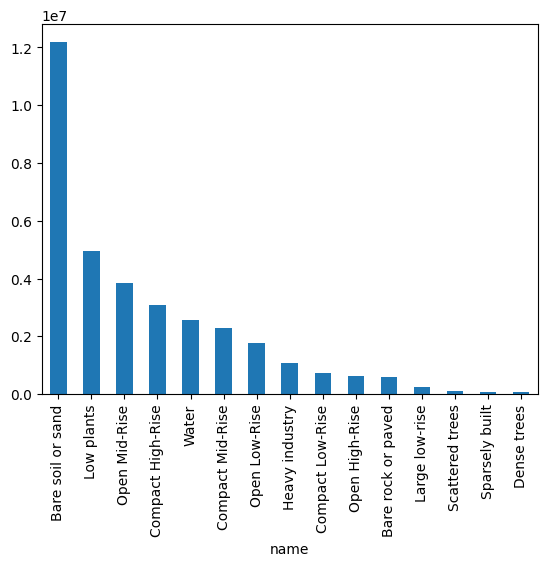

In [15]:



lcz_gdf.groupby('name').area_m2.sum().sort_values(ascending=False).plot.bar()
m=study_area.explore()
lcz_gdf.explore(
    column='name',
    m=m
)

### 3.2. Rasterize and Export 

In [16]:

# Remove Open High-rise Class (poor training data)

lcz_gdf = lcz_gdf[lcz_gdf['class'] != 4]
## Train Samples Rasterization
rasterize_vector(gdf=lcz_gdf,
                 ref=s2_ref,
                 attribute="class",
                 crs=s2.rio.crs,
                 out_path=TRAIN_FP,
                 )

# ## Test Samples Rasterization
# rasterize_vector(gdf=lcz_test,
#                  ref=s2_ref,
#                  attribute="class",
#                  crs=s2.rio.crs,
#                  out_path=TEST_FP,
#                  )

